In [1]:
# 코랩에서 시행시 설치해줘야함.
## 설치 완료 후 상위 메뉴에서 런타임 -> 세션 다시시작 해줘야함.

!pip install numpy==1.26.4
!pip install scipy==1.11.1
!pip install pandas==2.1.4
!pip install scikit-learn==1.4.2
!pip install joblib==1.3.0
!pip install catboost==1.2.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import sparse, special, stats

# Machine Learning
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scipy.special import softmax

# Parallel Processing
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial

# Data Structure and Iteration
from collections import defaultdict
from itertools import combinations, permutations

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# System and Utilities
import os
import re
import random
import warnings
import contextlib
import itertools
from typing import List, Set, Dict, Tuple, Optional
import json

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score

# 데이터 불러오기 (TMAS 데이터)

In [2]:
# TMAS
url = 'https://raw.githubusercontent.com/novicedata/Grove_CAT/refs/heads/main/data/TMA.csv'
data = pd.read_csv(url)

In [3]:
data

,score,gender,age,Q1,Q2,Q3,Q4,Q5,Q6,Q7,...,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50
0,32,2,56,2,2,2,1,2,1,2,...,2,1,1,1,2,1,1,1,2,2
1,17,1,30,1,2,1,1,2,1,1,...,1,1,2,2,2,2,2,2,2,2
2,41,1,32,2,1,1,2,1,1,1,...,1,1,1,2,1,1,2,1,1,2
3,31,1,29,1,2,2,1,1,1,1,...,1,2,1,1,1,1,1,2,1,2
4,35,1,23,1,2,2,1,1,2,1,...,2,1,1,1,1,1,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,35,1,27,2,2,2,2,1,1,2,...,1,1,1,1,1,1,1,1,1,2
5406,31,2,24,1,2,2,1,1,1,0,...,1,1,1,2,1,1,1,1,2,2
5407,4,1,22,1,2,1,1,2,2,2,...,2,2,2,1,2,2,2,2,2,1
5408,41,1,16,1,2,1,2,1,1,1,...,1,1,1,1,1,1,1,1,2,2


# 데이터 정제

선행연구에 따라 점수를 총 4개의 클래스 레이블로 지정

In [4]:
# TMA
# gender가 3 또는 0인 행 제거
data.drop(data[(data['gender'] == 3) | (data['gender'] == 0)].index, inplace=True)

# age가 14세 미만 또는 80세 초과인 행 제거
data.drop(data[(data['age'] < 14) | (data['age'] > 80)].index, inplace=True)

# 0값이 있는 행 제거 (Q1~Q50 컬럼에서)
for col in data.columns[4:54]:  # Q1~Q50에 해당하는 컬럼들
    data.drop(data[data[col] == 0].index, inplace=True)

data.reset_index(inplace=True, drop=True)  # 인덱스 리셋

# 필요한 컬럼만 남김 (Q1 ~ Q50)
X = data.iloc[:, 3:55]
y = data['score']

# 라벨링 함수 정의
def label_anxiety(score):
    if 5 <= score <= 15:
        return 'low anxiety'
    elif 15 < score <= 39:
        return 'moderate anxiety'
    elif 40 <= score <= 50:
        return 'severe anxiety'
    else:
        return 'no anxiety'  # 점수가 지정된 범위에 없는 경우

# y 값에 라벨링 적용
y = y.apply(label_anxiety)

In [5]:
y.value_counts()

,count
score,
moderate anxiety,3054
severe anxiety,1123
low anxiety,250
no anxiety,25


In [6]:
X

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50
0,2,2,2,1,2,1,2,2,1,2,...,2,1,1,1,2,1,1,1,2,2
1,1,2,1,1,2,1,1,2,1,2,...,1,1,2,2,2,2,2,2,2,2
2,2,1,1,2,1,1,1,1,1,1,...,1,1,1,2,1,1,2,1,1,2
3,1,2,2,1,1,1,1,2,2,2,...,1,2,1,1,1,1,1,2,1,2
4,1,2,2,1,1,2,1,1,1,1,...,2,1,1,1,1,1,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4447,2,2,2,1,1,1,1,2,2,1,...,1,1,1,1,1,1,1,1,1,2
4448,2,2,2,2,1,1,2,2,2,2,...,1,1,1,1,1,1,1,1,1,2
4449,1,2,1,1,2,2,2,2,2,2,...,2,2,2,1,2,2,2,2,2,1
4450,1,2,1,2,1,1,1,1,2,2,...,1,1,1,1,1,1,1,1,2,2


### 다중 분류이기 때문에 train catboost 함수 또한 단일 분류와 다름

In [7]:
def train_catboost(X_train, y_train, X_test, y_test,
                            max_depth=3,
                            n_estimators=100,
                            learning_rate=1,
                            min_child_samples=1,
                            random_state=42,
                            auto_class_weights=None):
    """
    다중분류를 위한 CatBoost 모델을 학습시키는 함수입니다.

    :param X_train: 학습 데이터
    :param y_train: 학습 데이터의 레이블
    :param X_test: 테스트 데이터
    :param y_test: 테스트 데이터의 레이블
    :param max_depth: 트리의 최대 깊이 (default: 3)
    :param n_estimators: 생성할 트리의 수 (default: 100)
    :param learning_rate: 학습률 (default: 1)
    :param subsample: 각 트리가 사용할 데이터의 비율 (default: 0.5)
    :param min_child_samples: 리프 노드의 최소 샘플 수 (default: 1)
    :param random_state: 랜덤 시드 (default: 42)
    :param auto_class_weights: 클래스 가중치 자동 설정 (default: None)
    :return: 학습된 모델과 파라미터
    """
    # 클래스 수 확인
    n_classes = len(np.unique(y_train))

    # 모델 파라미터 설정
    params = {
        'loss_function': 'MultiClass',  # 다중분류용 손실함수
        'eval_metric': 'MultiClass',    # 다중분류용 평가지표
        'learning_rate': learning_rate,
        'grow_policy' : 'Lossguide',
        'depth': max_depth,
        'random_seed': random_state,
        'iterations': n_estimators,
        'verbose': False,
        'thread_count': -1,
        'auto_class_weights': auto_class_weights,
        'classes_count': n_classes      # 클래스 수 지정
    }

    # Pool 생성
    train_pool = Pool(data=X_train, label=y_train)
    test_pool = Pool(data=X_test, label=y_test)

    # 모델 생성 및 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool,
              eval_set=test_pool,
              verbose=False)

    # 학습 데이터에 대한 예측 및 정확도 계산
    y_pred_train = model.predict(train_pool)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    print(f"Final model accuracy on train data: {train_accuracy:.4f}")

    # 테스트 데이터에 대한 예측 및 정확도 계산
    y_pred_test = model.predict(test_pool)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Final model accuracy on test data: {test_accuracy:.4f}")

    # 클래스별 확률 예측 및 ROC AUC 계산 (클래스가 3개 이상인 경우)
    if n_classes > 2:
        y_pred_proba_test = model.predict_proba(test_pool)
        # 레이블 이진화
        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

        # 클래스별 AUC 계산
        for i in range(n_classes):
            class_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba_test[:, i])
            print(f"AUC for class {i}: {class_auc:.4f}")

    return model, params

### Grove 함수

다중분류 이기에 softmax 적용

나무 구조 또한 단일 분류 나무구조와 다르기 때문에 그에 맞게 코드 수정

In [8]:
class Grove:
    def __init__(self):
        # 캐시 초기화: 트리 경로, feature, 예측값에 대한 캐시를 각각 딕셔너리로 생성
        self._path_cache: Dict[int, List[Dict]] = {}  # 트리 경로 캐시
        self._feature_cache: Dict[int, Set[str]] = {}  # feature 캐시
        self._prediction_cache: Dict[Tuple[int, int], np.ndarray] = {}  # 예측값 캐시

    def softmax(self, x):
        """
        수치적으로 안정적인 softmax 함수 구현
        Args:
            x: shape (n_samples, n_classes)의 입력 배열
        Returns:
            softmax 확률 벡터
        """
        shifted_x = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(shifted_x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def get_tree_paths(self, tree_data: Dict, splits: List[Dict], leaf_values: List[float], tree_idx: Optional[int] = None) -> List[Dict]:
        """
        주어진 트리 데이터를 바탕으로 모든 가능한 경로를 추출합니다.
        - 각 경로에서 만나게 되는 feature들을 추출하고, 리프 노드에서의 값을 기록합니다.
        - 캐시를 사용하여 동일한 트리에 대해 중복된 계산을 피합니다.
        - CatBoost의 Lossguide 트리 구조에 맞게 경로 탐색을 수행.
        """
        if tree_idx is not None and tree_idx in self._path_cache:
            return self._path_cache[tree_idx]

        paths = []

        def traverse_tree(node_idx=0, current_features=None):
            if current_features is None:
                current_features = set()

            # 리프 노드인 경우 처리
            if node_idx >= len(splits) or "leaf_values" in splits[node_idx]:
                leaf_value = splits[node_idx].get("leaf_values", leaf_values[node_idx - len(splits)])
                paths.append({
                    'features': current_features.copy(),
                    'value': leaf_value
                })
                return

            # 내부 노드의 feature 기록
            split = splits[node_idx]
            if "float_feature_index" in split:
                current_features.add(split["float_feature_index"])

            left_idx = split.get("left_child_index", 2 * node_idx + 1)
            right_idx = split.get("right_child_index", 2 * node_idx + 2)

            if left_idx < len(splits):
                traverse_tree(left_idx, current_features.copy())
            if right_idx < len(splits):
                traverse_tree(right_idx, current_features.copy())

        traverse_tree()

        if tree_idx is not None:
            self._path_cache[tree_idx] = paths

        return paths

    def extract_features_from_node(self, node):
        """
        트리 노드를 재귀적으로 순회하면서 feature를 추출합니다.
        - 각 노드가 split을 가지고 있으면 해당 feature를 추출하고,
        - 왼쪽과 오른쪽 자식 노드에서도 동일한 작업을 수행합니다.
        """
        features = set()  # 최종적으로 반환할 feature 인덱스를 저장할 집합

        # 현재 노드가 split 조건을 가지고 있는 경우
        if 'split' in node:
            split = node['split']  # split 정보 추출
            if 'float_feature_index' in split:
                # split에서 사용된 float feature 인덱스를 추가
                features.add(split['float_feature_index'])

        # 왼쪽 자식 노드가 존재하고, 그것이 딕셔너리 형식일 경우
        if 'left' in node and isinstance(node['left'], dict):
            # 왼쪽 서브트리에서 추출한 feature들을 병합
            features.update(self.extract_features_from_node(node['left']))

        # 오른쪽 자식 노드가 존재하고, 그것이 딕셔너리 형식일 경우
        if 'right' in node and isinstance(node['right'], dict):
            # 오른쪽 서브트리에서 추출한 feature들을 병합
            features.update(self.extract_features_from_node(node['right']))

        return features  # 전체 서브트리에서 추출된 feature 인덱스 집합 반환

    def extract_tree_features(self, model: CatBoostClassifier or CatBoostRegressor, tree_idx: Optional[int] = None):
        """
        주어진 CatBoost 모델에서 트리별로 사용된 모든 feature를 추출합니다.
        - 모델을 JSON 형식으로 저장하고 이를 로드하여 트리 구조를 파싱합니다.
        - 캐시를 사용하여 동일한 트리에 대해 중복된 작업을 피합니다.
        """
        # 특정 트리 인덱스가 주어졌고, 해당 트리의 feature 정보가 캐시에 존재하면 즉시 반환
        if tree_idx is not None and tree_idx in self._feature_cache:
            return self._feature_cache[tree_idx]

        # 모델을 임시 JSON 파일로 저장 (CatBoost는 JSON 포맷으로 트리 구조 제공)
        temp_json_file = "temp_model.json"
        model.save_model(temp_json_file, format="json")

        # 저장한 JSON 파일을 열고 전체 모델 구조를 파싱
        with open(temp_json_file, "r") as f:
            model_json = json.load(f)

        trees = model_json["trees"]  # 트리 리스트를 추출

        if tree_idx is not None:
            # 단일 트리만 처리하는 경우
            tree_data = trees[tree_idx]  # 해당 트리 데이터 추출
            features = self.extract_features_from_node(tree_data)  # 해당 트리에서 feature 추출
            self._feature_cache[tree_idx] = features  # 캐시에 저장
            return features  # 추출된 feature 반환
        else:
            # 전체 트리에 대해 반복적으로 feature 추출 수행
            features = []
            for i, tree_data in enumerate(trees):
                # 각 트리에 대해 재귀 호출하여 feature 추출 (캐시가 자동 적용됨)
                features.append(self.extract_tree_features(model, i))
            return features  # 전체 트리에 대한 feature 리스트 반환

    def get_path_features_from_node(self, node, current_features=None):
        """
        주어진 노드에서 모든 가능한 경로의 feature 집합을 추출합니다.
        - 재귀적으로 왼쪽과 오른쪽 자식 노드를 순회하며 경로를 기록합니다.
        """
        if current_features is None:
            current_features = set()  # 현재까지의 경로에서 만난 feature들을 저장할 집합 초기화

        # 리프 노드에 도달한 경우
        if 'value' in node:
            return [current_features.copy()]  # 해당 경로에서의 feature 집합을 반환 (리스트에 담아서 반환)

        # 현재 노드가 split을 가지고 있으면 feature 인덱스를 추가
        if 'split' in node:
            current_features.add(node['split']['float_feature_index'])

        paths = []  # 모든 경로의 feature 집합을 저장할 리스트

        # 왼쪽 자식 노드가 존재하면 재귀적으로 탐색
        if 'left' in node:
            left_paths = self.get_path_features_from_node(node['left'], current_features.copy())
            paths.extend(left_paths)  # 왼쪽에서 얻은 경로들을 리스트에 추가

        # 오른쪽 자식 노드가 존재하면 재귀적으로 탐색
        if 'right' in node:
            right_paths = self.get_path_features_from_node(node['right'], current_features.copy())
            paths.extend(right_paths)  # 오른쪽에서 얻은 경로들을 리스트에 추가

        return paths  # 모든 리프 노드 경로에서의 feature 집합 리스트를 반환

    def calculate_item_range(self, model, tree_indices):
        """
        주어진 트리 인덱스들에 대해 최소/최대 문항 수를 계산합니다.
        - 트리의 가능한 경로들을 feature set으로 변환한 뒤, 모든 경로 조합을 계산하여 문항 수를 측정합니다.
        """
        # 각 트리의 가능한 경로들을 feature 집합으로 변환하여 저장할 리스트
        tree_feature_sets = []

        # 모델 구조를 JSON 형식으로 임시 파일에 저장
        temp_json_file = "temp_model.json"
        model.save_model(temp_json_file, format="json")

        # 저장한 JSON 파일을 열어서 모델 구조를 로드
        with open(temp_json_file, "r") as f:
            model_json = json.load(f)

        # 트리 정보는 "trees" 키에 저장되어 있음
        trees = model_json["trees"]

        # 각 트리 인덱스에 대해 가능한 경로별 feature 집합을 추출
        for tree_idx in tree_indices:
            tree_data = trees[tree_idx]  # 해당 트리 구조 가져오기
            path_feature_sets = self.get_path_features_from_node(tree_data)  # 모든 경로별 feature set 추출
            tree_feature_sets.append(path_feature_sets)  # 트리별 리스트에 저장

        # 최소/최대 문항 수 초기값 설정
        min_items = float('inf')  # 최소값을 비교 위해 무한대로 시작
        max_items = 0             # 최대값은 0부터 시작

        # 각 트리에서 가능한 모든 경로 조합(product)을 생성
        '''
        # 계산량의 문제로 비활성화
        for path_combination in itertools.product(*tree_feature_sets):
            total_features = set().union(*path_combination)  # 경로 조합에서 등장한 모든 feature들의 합집합
            num_features = len(total_features)  # 사용된 feature의 개수 (문항 수)

            # 현재 경로 조합에서의 문항 수로 최소/최대 갱신
            min_items = min(min_items, num_features)
            max_items = max(max_items, num_features)
        '''

        # 최소 문항 수가 여전히 무한대면 문항 없음 → 0 반환
        return min_items if min_items != float('inf') else 0, max_items

    @contextlib.contextmanager
    def _temporary_pool(self, pool):
        """
        CatBoost Pool 객체를 메모리 효율적으로 사용하기 위한 컨텍스트 매니저
        사용 후 자동 삭제 처리
        """
        try:
            yield pool
        finally:
            del pool

    @staticmethod
    def optimize_numeric_dtypes(arr):
        """
        배열의 데이터 타입을 최적화하여 메모리 효율을 개선합니다.
        - 각 숫자형 배열의 최적의 데이터 타입을 자동으로 선택합니다.
        """
        # 리스트나 튜플로 들어온 경우 NumPy 배열로 변환
        if isinstance(arr, (list, tuple)):
            arr = np.array(arr)

        # 정수형 배열인 경우
        if np.issubdtype(arr.dtype, np.integer):
            min_val, max_val = arr.min(), arr.max()  # 최소값과 최대값 계산

            if min_val >= 0:
                # unsigned int로 다운캐스팅 시도
                if max_val <= np.iinfo(np.uint8).max:
                    return arr.astype(np.uint8)  # 가장 작은 unsigned 정수
                elif max_val <= np.iinfo(np.uint16).max:
                    return arr.astype(np.uint16)  # 그 다음 크기의 unsigned 정수
            else:
                # signed int로 다운캐스팅 시도
                if min_val >= np.iinfo(np.int8).min and max_val <= np.iinfo(np.int8).max:
                    return arr.astype(np.int8)  # 가장 작은 signed 정수
                elif min_val >= np.iinfo(np.int16).min and max_val <= np.iinfo(np.int16).max:
                    return arr.astype(np.int16)  # 그 다음 크기의 signed 정수

        # 부동소수점형 배열인 경우
        elif np.issubdtype(arr.dtype, np.floating):
            # float64 값을 float32로 변환해도 값 손실이 없을 경우 다운캐스팅
            if np.allclose(arr, arr.astype(np.float32)):
                return arr.astype(np.float32)

        # 다운캐스팅이 불가능한 경우 원래 배열을 그대로 반환
        return arr

    def get_tree_predictions_multiclass(self, model, pool, tree_idx, n_classes, chunk_size=1000):
        """
        각 트리에 대해 다중 분류용 예측값을 계산합니다.
        - RawFormulaVal 값을 받아서 각 클래스에 대한 raw score (logit 값)를 반환합니다.

        Args:
            model: 학습된 CatBoost 모델
            pool: CatBoost Pool 객체 (예측에 사용할 데이터셋)
            tree_idx: 예측에 사용할 단일 트리 인덱스
            n_classes: 클래스 수 (출력 차원)
            chunk_size: 데이터를 나눠서 처리할 크기 (메모리 최적화 목적)

        Returns:
            (n_samples, n_classes) 형태의 NumPy 배열로, 각 샘플의 클래스별 raw 예측값을 반환
        """
        cache_key = (id(model), tree_idx)  # 캐시에서 예측값을 찾기 위한 고유 키 생성 (모델 객체 ID + 트리 번호)

        # 캐시에 해당 트리의 예측값이 존재하면 즉시 반환
        if cache_key in self._prediction_cache:
            return self._prediction_cache[cache_key]

        n_samples = pool.num_row()  # 전체 샘플 수
        predictions = np.zeros((n_samples, n_classes), dtype=np.float32)  # 예측값을 저장할 배열 초기화

        # 데이터를 chunk 단위로 나누어 반복 처리
        for chunk_start in range(0, n_samples, chunk_size):
            chunk_end = min(chunk_start + chunk_size, n_samples)  # 청크 끝 인덱스 계산
            chunk_indices = list(range(chunk_start, chunk_end))   # 현재 청크의 샘플 인덱스 범위

            # 현재 청크에 대한 Pool 객체 생성 및 예측 수행
            with self._temporary_pool(pool.slice(chunk_indices)) as chunk_pool:
                # RawFormulaVal: softmax 적용 전 logit 값을 반환 (다중 클래스용)
                chunk_predictions = model.predict(
                    chunk_pool,
                    prediction_type="RawFormulaVal",  # 클래스별 logit 값 출력
                    ntree_start=tree_idx,             # 특정 트리부터 시작
                    ntree_end=tree_idx + 1            # 해당 트리까지만 사용
                )
                # 예측 결과를 전체 prediction 배열의 해당 위치에 저장
                predictions[chunk_start:chunk_end] = chunk_predictions

        # 계산된 결과를 캐시에 저장하여 이후 재사용 가능하게 함
        self._prediction_cache[cache_key] = predictions
        return predictions  # 전체 샘플에 대한 해당 트리의 raw 예측값 반환


    def get_tree_predictions(self, model, pool, num_trees, chunk_size=1000):
        """
        전체 트리에 대해 예측값 배열을 생성합니다.
        - 각 트리에 대해 (샘플 수 × 클래스 수) 형태의 예측값을 계산한 뒤,
          이를 (트리 수 × 샘플 수 × 클래스 수) 형태의 3차원 배열로 결합합니다.

        Returns:
            shape = (n_trees, n_samples, n_classes) 형태의 NumPy 배열
        """
        n_classes = model.classes_.shape[0]  # 클래스 수 확인 (다중분류 문제 기준)

        # 각 트리에 대해 다중분류용 예측값을 계산하고 리스트로 수집
        predictions_by_tree = [
            self.get_tree_predictions_multiclass(model, pool, tree_idx, n_classes, chunk_size)
            for tree_idx in range(num_trees)  # 0번부터 num_trees-1번까지 순회
        ]

        # 리스트를 3차원 배열로 변환하여 반환 (트리별, 샘플별, 클래스별 예측값)
        return np.array(predictions_by_tree)


    def find_optimal_tree_groups(self, tree_features, min_num_trees, max_num_trees, num_classes, required_features=None):
        """
        트리 개수 범위를 만족하고 필수 feature를 포함하는 모든 가능한 트리 조합을 찾습니다.

        Args:
            tree_features: 각 트리별로 사용된 feature들의 집합이 들어있는 리스트
            min_num_trees: 트리 조합의 최소 개수
            max_num_trees: 트리 조합의 최대 개수
            num_classes: 클래스 개수
            required_features: 포함되어야 할 필수 feature들의 집합 (선택적)

        Returns:
            조건을 만족하는 트리 인덱스 조합 리스트
        """
        num_trees = len(tree_features)  # 전체 트리 개수
        results = []  # 조건을 만족하는 트리 조합을 저장할 리스트

        # 필수 feature가 주어진 경우 집합 형태로 변환, 없으면 빈 집합으로 처리
        required_features = set(required_features) if required_features else set()

        # 트리 개수가 min~max 범위 내에 있을 때 가능한 모든 조합 탐색
        for num_trees_in_group in range(min_num_trees, min(max_num_trees + 1, num_trees + 1)):
            # 해당 개수의 트리 조합 생성 (예: 3개짜리, 4개짜리 조합 등)
            for trees in itertools.combinations(range(num_trees), num_trees_in_group):
                # 선택된 트리들의 feature 집합을 모두 합침 (중복 제거된 union)
                combined_features = set().union(*[tree_features[tree_idx] for tree_idx in trees])

                # 필수 feature 조건을 만족하는 경우에만 결과 리스트에 추가
                if not required_features or required_features.issubset(combined_features):
                    results.append(list(trees))  # 튜플 대신 리스트 형태로 저장

        return results  # 조건을 만족하는 트리 인덱스 조합 리스트 반환

    def process_tree_groups_batch(self, combinations_batch, predictions_by_tree, y, tree_features, num_classes):
        """
        주어진 트리 조합에 대해 softmax, AUC, Accuracy 및 feature 통계를 계산하여 결과 리스트로 반환합니다.

        Args:
            combinations_batch: 평가할 트리 조합들의 리스트 (ex: [[0, 2, 4], [1, 3, 5]] 등)
            predictions_by_tree: 각 트리에 대한 예측값 배열 (shape: [n_trees, n_samples, n_classes])
            y: 실제 타깃 레이블 벡터 (다중)
            tree_features: 트리별로 사용된 feature 집합 리스트
            num_classes: 클래스 개수

        Returns:
            트리 조합별 성능 및 특성 정보를 포함한 딕셔너리 리스트
        """
        results = []  # 결과를 저장할 리스트

        for group in combinations_batch:
            # 선택된 트리 그룹의 예측값을 합산하여 앙상블 예측값 계산 (로짓 합)
            predictions_sum = np.sum([predictions_by_tree[tree] for tree in group], axis=0)

            # softmax 안정성을 위해 logit에서 max를 빼줌 (overflow 방지)
            shifted_logits = predictions_sum - np.max(predictions_sum, axis=1, keepdims=True)

            # softmax 확률 계산
            exp_preds = np.exp(shifted_logits)
            predictions_prob = exp_preds / exp_preds.sum(axis=1, keepdims=True)  # 확률로 변환된 예측값

            # 최종 클래스 예측 (확률이 가장 높은 클래스 선택)
            predictions_class = np.argmax(predictions_prob, axis=1)

            # 다중분류 ROC-AUC (OVR 방식) 계산
            auc = roc_auc_score(y, predictions_prob, multi_class='ovr')

            # 정확도 계산
            acc = accuracy_score(y, predictions_class)

            # 트리 그룹에서 사용된 feature 목록 수집
            tree_feature_sets = [tree_features[tree] for tree in group]
            all_features = set().union(*tree_feature_sets)

            # 각 feature가 몇 개의 트리에서 사용되었는지 카운트
            feature_count = {}
            for feature_set in tree_feature_sets:
                for feature in feature_set:
                    feature_count[feature] = feature_count.get(feature, 0) + 1

            # 두 개 이상의 트리에서 중복 사용된 feature
            overlapping_features = {f for f, count in feature_count.items() if count > 1}

            # 한 개의 트리에서만 사용된 독립 feature
            independent_features = {f for f, count in feature_count.items() if count == 1}

            # 결과 저장: 그룹 구성, AUC, ACC, feature 정보 등
            results.append({
                'groups': [group],  # 트리 인덱스 리스트
                'auc': auc,  # 다중분류 AUC
                'acc': acc,  # 정확도
                'overlapping_items': len(overlapping_features),  # 중복 feature 수
                'independent_items': len(independent_features),  # 고유 feature 수
                'features': [all_features],  # 전체 feature 집합
            })

        return results  # 평가 결과 리스트 반환


    def create_results_dataframe(self, results, model, n_jobs=-1):
        """
        분석 결과를 정리하여 DataFrame으로 반환하고, 성능 중복 제거 및 정렬 수행

        Args:
            results: 트리 그룹별 평가 결과 리스트 (dict 형태)
            model: CatBoost 모델 (현재는 사용하지 않지만 구조상 포함됨)
            n_jobs: 병렬 처리 시 사용할 스레드 수 (미사용 시 전체 코어 사용)

        Returns:
            평가 결과를 정리한 pandas DataFrame
        """
        print(f"Processing {len(results)} results...")

        # 청크 단위로 나누어 처리 (메모리 및 출력 최적화 목적)
        chunk_size = 10
        result_chunks = [results[i:i + chunk_size] for i in range(0, len(results), chunk_size)]

        df_chunks = []  # 청크별 DataFrame 저장용 리스트

        for chunk_idx, chunk in enumerate(result_chunks):
            # 하나의 청크를 DataFrame으로 변환
            chunk_df = pd.DataFrame([{
                'Model Performance AUC': round(result['auc'], 4),  # ROC-AUC 점수
                'Model Performance ACC': round(result['acc'], 4),  # 정확도
                'Tree Count': len(result['groups'][0]),  # 사용된 트리 개수
                'Tree Indices': result['groups'][0],  # 트리 인덱스 조합
                'Item List': sorted(list(result['features'][0])),  # 사용된 문항(feature) 리스트
                'Total Items': len(result['features'][0]),  # 전체 문항 수
                'Shared Items': result['overlapping_items'],  # 중복 문항 수
                'Unique Items': result['independent_items'],  # 고유 문항 수
                'Min Items/Person': result['min_items'],  # 수험자 기준 최소 문항 수
                'Max Items/Person': result['max_items']   # 수험자 기준 최대 문항 수
            } for result in chunk])
            df_chunks.append(chunk_df)

        # 모든 청크를 하나의 DataFrame으로 통합
        initial_df = pd.concat(df_chunks, ignore_index=True)

        # 중복 제거:
        # 동일한 Item List 조합이 있을 경우, AUC가 가장 높은 결과만 선택
        initial_df['items_tuple'] = initial_df['Item List'].apply(tuple)  # 리스트를 튜플로 변환하여 groupby 가능하게 함
        final_max_indices = initial_df.groupby('items_tuple')['Model Performance AUC'].idxmax()  # AUC 기준 최고 점수 인덱스 추출
        unique_df = initial_df.loc[final_max_indices].copy()  # 해당 인덱스만 남기기
        unique_df = unique_df.sort_values('Tree Count').drop('items_tuple', axis=1)  # Tree Count 기준으로 정렬 후 중복 제거 컬럼 삭제

        # 컬럼 순서를 재정렬
        column_order = [
            'Model Performance AUC', 'Model Performance ACC', 'Tree Count',
            'Tree Indices', 'Item List', 'Total Items',
            'Shared Items', 'Unique Items',
            'Min Items/Person', 'Max Items/Person'
        ]
        results_df = unique_df[column_order].sort_values('Model Performance ACC', ascending=False).reset_index(drop=True)

        # float64 컬럼을 float32로 다운캐스팅하여 메모리 최적화
        for col in results_df.columns:
            if results_df[col].dtype == 'float64':
                results_df[col] = results_df[col].astype('float32')

        print(f"Processing completed. Found {len(results_df)} unique combinations.")
        return results_df  # 최종 결과 DataFrame 반환


    def analyze(self, param, X, y, model, tree_range, percentile=100, required_features=None, n_jobs=-1):
        """
        메인 분석 함수
        주어진 모델을 바탕으로 최적 트리 조합을 찾고 성능을 평가합니다.

        Args:
            param: CatBoost 모델 파라미터 (사용하지 않지만 포맷 유지용)
            X: 입력 데이터 (numpy array 또는 DataFrame)
            y: 타깃 레이블
            model: 학습된 CatBoost 모델
            tree_range: 탐색할 트리 수 범위 (예: (3, 5))
            percentile: 상위 몇 % 결과만 필터링할지 지정
            required_features: 반드시 포함되어야 하는 feature 리스트 (optional)
            n_jobs: 사용할 병렬 처리 스레드 수

        Returns:
            평가 결과를 정리한 pandas DataFrame
        """
        print("Initializing analysis...")

        # 필수 feature가 지정된 경우, 실제 feature와 비교하여 누락 여부 확인
        if required_features and isinstance(X, pd.DataFrame):
            print(f"Required features: {required_features}")
            missing_features = set(required_features) - set(X.columns)
            if missing_features:
                raise ValueError(f"Required features not found in data: {missing_features}")

        # 모델 트리 수 확인 및 범위 검증
        num_trees = model.tree_count_
        print(f"Number of trees: {num_trees}")

        min_trees, max_trees = tree_range
        if min_trees < 1:
            raise ValueError("Minimum number of trees must be at least 1")
        if max_trees > num_trees:
            raise ValueError(f"Maximum number of trees cannot exceed total trees ({num_trees})")
        if min_trees > max_trees:
            raise ValueError("Minimum number of trees cannot be greater than maximum")

        # 데이터 전처리 함수 정의
        def prepare_data(X):
            if isinstance(X, pd.DataFrame):
                feature_names = X.columns.tolist()
                X_numpy = np.column_stack([
                    self.optimize_numeric_dtypes(X[col].values)
                    for col in X.columns
                ])
                return X_numpy, feature_names
            return self.optimize_numeric_dtypes(X), None

        # 데이터 변환 (DataFrame이면 feature 이름도 함께 추출)
        X_processed, feature_names = prepare_data(X)

        # CatBoost Pool 객체 생성
        pool = Pool(
            data=X_processed,
            label=y,
            feature_names=feature_names if feature_names else None
        )

        # 트리 특성 추출
        print("Extracting tree features...")
        tree_features = self.extract_tree_features(model)

        # 트리별 예측값 계산
        print("Step 1: Calculating predictions for each tree...")
        chunk_size = min(1000, max(100, pool.num_row()))
        predictions_by_tree = self.get_tree_predictions(model, pool, model.tree_count_, chunk_size)

        # 유효한 트리 조합 찾기
        print("Step 2: Finding optimal tree groups...")
        valid_combinations = self.find_optimal_tree_groups(
            tree_features, min_trees, max_trees, len(model.classes_), required_features
        )

        if not valid_combinations:
            print(f"\n지정한 트리 개수 범위({min_trees}-{max_trees}) 내의 조합을 찾을 수 없습니다.")
            return None

        # 배치 처리 설정
        n_jobs = n_jobs if n_jobs > 0 else os.cpu_count()
        batch_size = max(1, len(valid_combinations) // (4 * n_jobs))

        # 배치 단위 병렬 처리
        initial_results = []
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            futures = [
                executor.submit(
                    self.process_tree_groups_batch,
                    valid_combinations[i:i + batch_size],
                    predictions_by_tree,
                    y,
                    tree_features,
                    len(model.classes_)
                )
                for i in range(0, len(valid_combinations), batch_size)
            ]

            # 결과 수집
            for idx, future in enumerate(as_completed(futures)):
                initial_results.extend(future.result())
                if (idx + 1) % 10 == 0:
                    print(f"Processed {idx + 1} batches out of {len(futures)}")

        # AUC 기준으로 결과 정렬 후 상위 percentile%만 남김
        initial_results.sort(key=lambda x: x['auc'], reverse=True)
        keep_count = int(np.ceil(len(initial_results) * (percentile / 100)))
        filtered_results = initial_results[:keep_count]
        print(f"Filtered to top {keep_count} results based on {percentile}% percentile")

        # 각 결과에 대해 최소/최대 문항 수 계산
        print("Calculating min/max items for filtered results...")
        final_results = [
            {
                **result,
                'min_items': min_items,
                'max_items': max_items
            }
            for result in filtered_results
            for min_items, max_items in [self.calculate_item_range(model, result['groups'][0])]
        ]

        # 결과를 DataFrame으로 변환
        results_df = self.create_results_dataframe(final_results, model, n_jobs=n_jobs)
        print(f"Final Combinations : {len(results_df)}")

        # pandas 출력 옵션 설정
        pd.set_option('display.max_colwidth', None)
        return results_df

    def predict(self, X_train, y_train, X_test, y_test, model, tree_indices):
        """
        주어진 트리 인덱스들로만 다중 분류 예측을 수행하고 성능을 평가합니다.

        Args:
            X_train: 학습 데이터
            y_train: 학습 데이터 레이블
            X_test: 테스트 데이터
            y_test: 테스트 데이터 레이블
            model: 학습된 CatBoost 모델
            tree_indices: 사용할 트리 인덱스 리스트

        Returns:
            예측 확률이 포함된 딕셔너리
        """

        # Pool 객체 생성
        train_pool = Pool(data=X_train, label=y_train)
        test_pool = Pool(data=X_test, label=y_test)

        # 클래스 수 확인
        n_classes = len(model.classes_)

        # 예측값을 저장할 배열 초기화 (raw score 누적용)
        train_predictions_sum = np.zeros((X_train.shape[0], n_classes), dtype=np.float32)
        test_predictions_sum = np.zeros((X_test.shape[0], n_classes), dtype=np.float32)

        # 지정된 트리 인덱스마다 raw 예측값을 계산하여 누적
        for tree_idx in tree_indices:
            # 학습 데이터 예측
            train_pred = model.predict(
                train_pool,
                prediction_type='RawFormulaVal',
                ntree_start=tree_idx,
                ntree_end=tree_idx + 1
            )
            train_predictions_sum += train_pred

            # 테스트 데이터 예측
            test_pred = model.predict(
                test_pool,
                prediction_type='RawFormulaVal',
                ntree_start=tree_idx,
                ntree_end=tree_idx + 1
            )
            test_predictions_sum += test_pred

        # 누적된 raw score에 softmax를 적용하여 확률값으로 변환
        train_probas = self.softmax(train_predictions_sum)
        test_probas = self.softmax(test_predictions_sum)

        # 학습 및 테스트 예측 확률을 딕셔너리로 반환
        return {
            'train_probas': train_probas,
            'test_probas': test_probas
        }




## Fig. 8.

### 데이터 분할:

전체 데이터를 테스트 세트(20%), 학습 세트(40%), 검증 세트(40%)로 분할.
                                       

### CatBoost 모델 초기 학습:

최대 깊이 10, 트리 개수 6개의 CatBoost 모델을 학습.
학습률(learning_rate)은 1로 설정.


### 최적 임계값 계산 함수 정의:

optimal_threshold 함수는 ROC 곡선을 기반으로 최적의 분류 임계값을 찾음.
이 임계값에서의 정확도(accuracy)도 함께 계산.


### Grove 분석 수행:

Grove 클래스를 사용해 분석을 실행.
3개부터 4개까지의 트리 조합을 분석합니다.
Grove 분석 결과를 바탕으로 검증 세트와 테스트 세트에 대한 성능을 평가.
각 트리 조합별로 항목 수, AUC, 정확도를 저장.


### CatBoost 모델 추가 평가:

Grove에서 찾은 최대 항목 수까지 반복하며 다양한 트리 개수의 모델을 평가.
각 반복마다 새로운 CatBoost 모델을 지정된 트리 수로 학습.
학습 및 테스트 세트에 대한 AUC와 정확도를 계산.
최적 임계값도 함께 저장.


### Decision Tree 모델 평가:

같은 범위에서 다양한 깊이의 Decision Tree 모델을 학습.
CatBoost와 마찬가지로 성능 지표를 계산하고 저장.


### 결과 시각화:

4 개의 서브플롯으로 구성된 그래프를 생성:

상단: ROC-AUC 점수 비교 ( 왼쪽은 train/vlaid set, 오른쪽은 test set )
하단: 정확도(Accuracy) 비교 ( 왼쪽은 train/vlaid set, 오른쪽은 test set )


각 그래프에는 세 가지 모델(CatBoost, Decision Tree, Grove)의 학습/검증/테스트 성능이 표시.

x축은 "사람당 최대 항목 수"를 나타냄.

Train set size: 1780
Validation set size: 1781
Test set size: 891
Final model accuracy on train data: 0.9079
Final model accuracy on test data: 0.8765
AUC for class 0: 0.9826
AUC for class 1: 0.9538
AUC for class 2: 0.9911
AUC for class 3: 0.9717
CatBoost evaluation completed
DT model ...
Done 

Initializing analysis...
Number of trees: 6
Extracting tree features...
Step 1: Calculating predictions for each tree...
Step 2: Finding optimal tree groups...
Filtered to top 35 results based on 100% percentile
Calculating min/max items for filtered results...
Processing 35 results...
Processing completed. Found 35 unique combinations.
Final Combinations : 35


<ipython-input-9-03b7df1ba5f2>:187: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(unique_tree_counts))


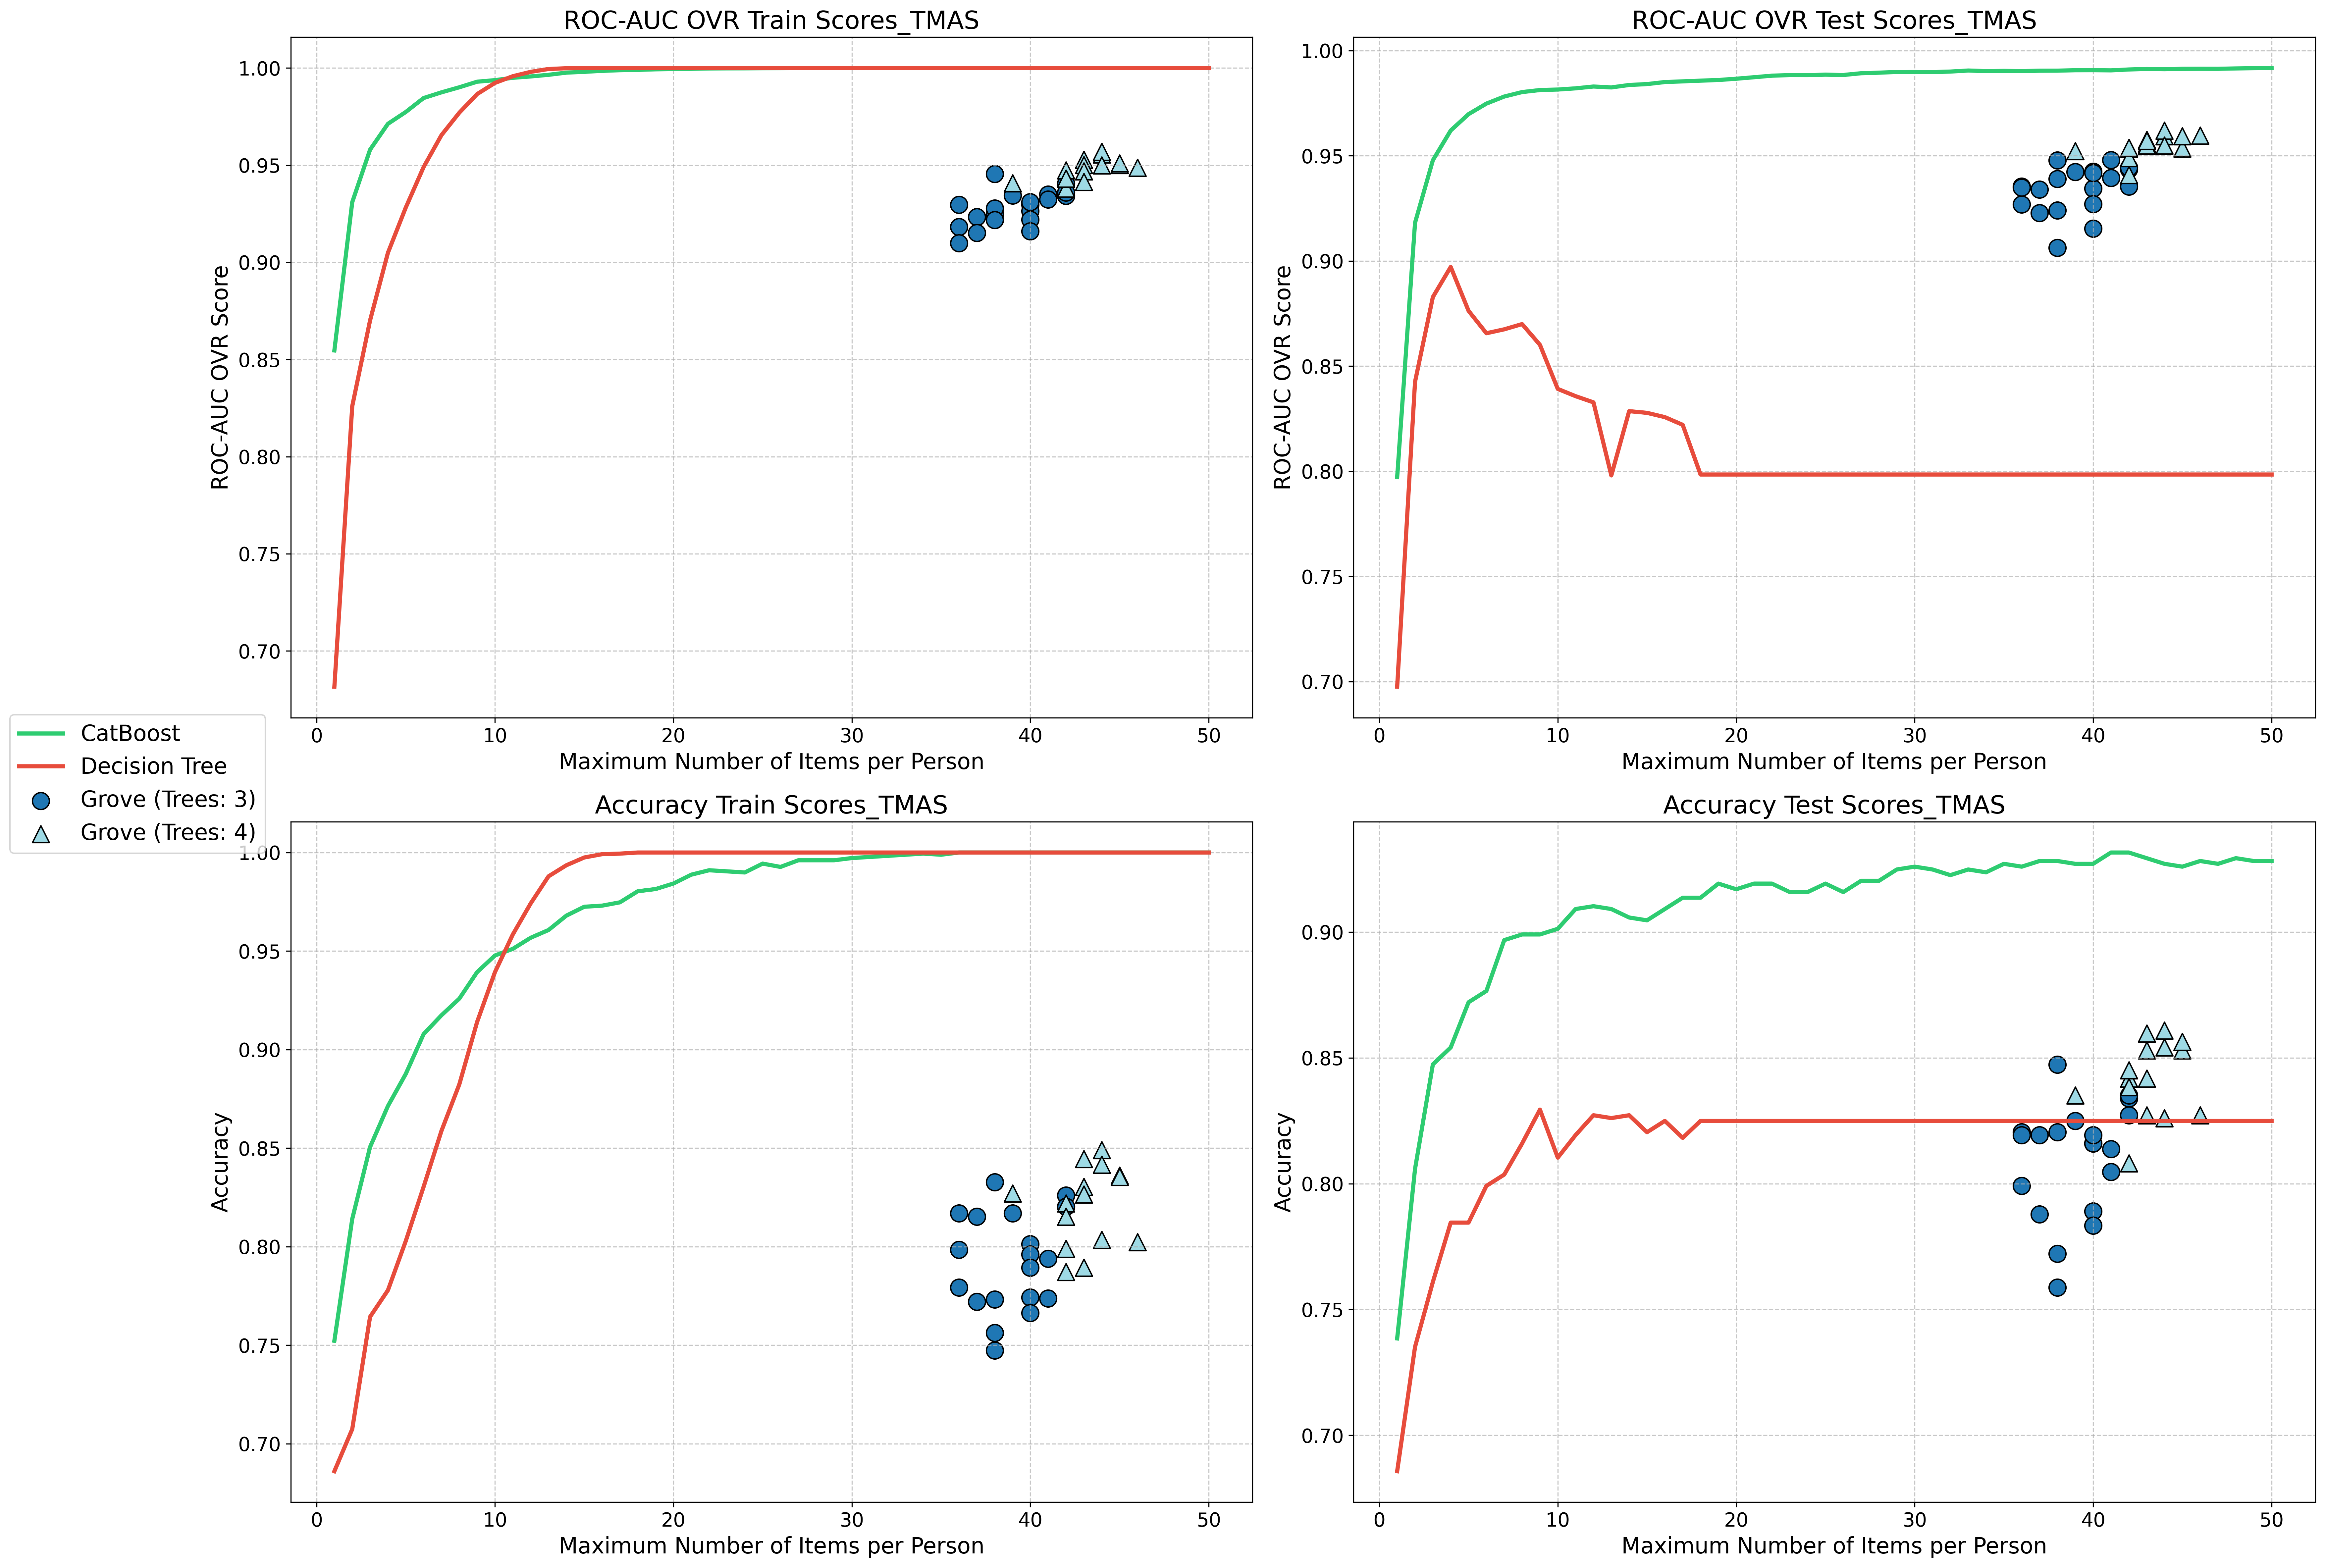

In [9]:
# 레이블 인코딩: y 값 (클래스 레이블)을 0부터 시작하는 정수로 변환
le = LabelEncoder()
y = le.fit_transform(y)
num_classes = 4  # 다중 분류 문제이므로 클래스 수를 4로 설정
grove = Grove()  # Grove 객체 생성

# 데이터 분할: 20%는 테스트 데이터로 분리, 나머지 80%를 학습 및 검증 데이터로 나눈다.
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# X_temp, y_temp는 학습 및 검증용 데이터를 나누기 위한 중간 데이터

# 데이터 분할 결과 출력
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}")
print(f"Test set size: {len(X_test)}")

# CatBoost 모델 학습을 위한 하이퍼파라미터 설정
trees_num = 6  # 트리 개수
max_depth = 10  # 트리 최대 깊이

# CatBoost 모델 학습
model, param = train_catboost(X_train, y_train, X_test, y_test,
                            max_depth=max_depth,
                            n_estimators=trees_num,
                            learning_rate=1,  # 학습률
                            min_child_samples=1,
                            random_state=42,
                            auto_class_weights=None)
# CatBoost 모델을 학습, 파라미터를 `train_catboost` 함수에서 설정

# CatBoost 및 Decision Tree 평가 결과를 저장할 딕셔너리
cat_results = {
    'train_auc': {}, 'test_auc': {},
    'train_acc': {}, 'test_acc': {},
    'thresholds': {}
}

dt_results = {
    'train_auc': {}, 'test_auc': {},
    'train_acc': {}, 'test_acc': {},
    'thresholds': {}
}

# CatBoost 모델 평가
cat_models = {}
cat_pred_tests = {}

# Pool 객체 생성: CatBoost 모델 학습 및 예측을 위해 학습 데이터와 테스트 데이터를 Pool 객체로 변환
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

# 트리 개수에 대해 CatBoost 모델 학습 및 평가
for n_tree in range(1, 51, 1):  # 1부터 50까지 트리 개수에 대해 모델을 학습
    # 모델 학습: 트리 개수를 n_tree로 설정
    params = param.copy()
    params['iterations'] = n_tree
    cat_model = CatBoostClassifier(**params)
    cat_model.fit(train_pool, verbose=False)
    cat_models[n_tree] = cat_model

    # 예측값 계산
    y_pred_train = cat_model.predict(train_pool, prediction_type='Probability')
    y_pred_test = cat_model.predict(test_pool, prediction_type='Probability')
    cat_pred_tests[n_tree] = y_pred_test

    # AUC (One-vs-Rest)와 Accuracy 계산
    train_auc = roc_auc_score(y_train, y_pred_train, multi_class='ovr')  # AUC 계산
    test_auc = roc_auc_score(y_test, y_pred_test, multi_class='ovr')    # AUC 계산

    train_acc = accuracy_score(y_train, np.argmax(y_pred_train, axis=1))  # 훈련 데이터 정확도 계산
    test_acc = accuracy_score(y_test, np.argmax(y_pred_test, axis=1))    # 테스트 데이터 정확도 계산

    # 결과 저장
    cat_results['train_auc'][n_tree] = train_auc
    cat_results['test_auc'][n_tree] = test_auc
    cat_results['train_acc'][n_tree] = train_acc
    cat_results['test_acc'][n_tree] = test_acc

print('CatBoost evaluation completed')

# Decision Tree 모델 학습 및 평가
print('DT model ...')
dt_models = {}
dt_pred_tests = {}
for max_depth in range(1, 51, 1):  # 1부터 50까지 트리 깊이에 대해 모델을 학습
    dt_model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt_model.fit(X_temp, y_temp)  # Decision Tree 모델 학습
    dt_models[max_depth] = dt_model

    y_pred_train = dt_model.predict_proba(X_temp)  # 학습 데이터 예측
    y_pred_test = dt_model.predict_proba(X_test)  # 테스트 데이터 예측
    dt_pred_tests[max_depth] = y_pred_test

    # AUC (One-vs-Rest)와 Accuracy 계산
    train_auc = roc_auc_score(y_temp, y_pred_train, multi_class='ovr')
    test_auc = roc_auc_score(y_test, y_pred_test, multi_class='ovr')

    train_acc = accuracy_score(y_temp, np.argmax(y_pred_train, axis=1))  # 훈련 데이터 정확도 계산
    test_acc = accuracy_score(y_test, np.argmax(y_pred_test, axis=1))    # 테스트 데이터 정확도 계산

    # 결과 저장
    dt_results['train_auc'][max_depth] = train_auc
    dt_results['test_auc'][max_depth] = test_auc
    dt_results['train_acc'][max_depth] = train_acc
    dt_results['test_acc'][max_depth] = test_acc

print('Done', '\n')

# Grove 분석
results = grove.analyze(param, X_valid, y_valid, model,
                       tree_range=(3, 4),
                       n_jobs=-1, percentile=100)
# Grove 모델을 사용하여, 3개 또는 4개의 트리로 이루어진 모델을 분석

# Decision Tree 결과를 DataFrame으로 변환
dt_df = pd.DataFrame({
    'n_items': list(dt_results['test_acc'].keys()),  # Decision Tree에서의 n_items (트리 개수)
    'dt_test_acc': list(dt_results['test_acc'].values())  # Decision Tree에서의 테스트 정확도
})

# Grove와 DT의 accuracy 비교하여 필터링
good_results = results.copy()
for idx, row in results.iterrows():
    # Grove 모델에서 예측 수행
    prediction_result = grove.predict(
        X_train=X_valid,
        y_train=y_valid,
        X_test=X_test,
        y_test=y_test,
        model=model,
        tree_indices=row['Tree Indices']
    )

    # 테스트 데이터 정확도 계산
    test_acc = accuracy_score(y_test, np.argmax(prediction_result['test_probas'], axis=1))

    # Grove 모델에서의 총 문항 수와 가장 근접한 Decision Tree의 정확도 비교
    n_items = row['Total Items']
    closest_depth = min(dt_df['n_items'], key=lambda x: abs(x - n_items))
    dt_acc = dt_df[dt_df['n_items'] == closest_depth]['dt_test_acc'].iloc[0]

    # Grove의 정확도가 Decision Tree의 정확도보다 낮으면 결과에서 제외
    if test_acc <= dt_acc:
        good_results = good_results.drop(idx)

good_results = good_results.reset_index(drop=True)

# Grove 결과 계산
grove_points = []
for _, row in results.iterrows():
    prediction_result = grove.predict(
        X_train=X_valid,
        y_train=y_valid,
        X_test=X_test,
        y_test=y_test,
        model=model,
        tree_indices=row['Tree Indices']
    )

    # 정확도 계산
    train_acc = accuracy_score(y_valid, np.argmax(prediction_result['train_probas'], axis=1))
    test_acc = accuracy_score(y_test, np.argmax(prediction_result['test_probas'], axis=1))

    grove_points.append({
        'n_items': row['Total Items'],
        'train_auc': row['Model Performance AUC'],
        'test_auc': roc_auc_score(y_test, prediction_result['test_probas'], multi_class='ovr'),
        'train_acc': train_acc,
        'test_acc': test_acc
    })

# 시각화 준비
grove_x = [p['n_items'] for p in grove_points]  # Grove 모델의 n_items 값 (문항 수)
grove_tree_counts = [len(r['Tree Indices']) for _, r in results.iterrows()]  # 각 Grove 모델의 트리 개수

# 시각화 설정
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12

# 시각화 그림 및 서브플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(24, 16), dpi=300)

# 트리 개수별로 색상과 모양 설정
unique_tree_counts = sorted(set(grove_tree_counts))
colors = cm.get_cmap('tab20', len(unique_tree_counts))
markers = ['o', '^', 's', 'D', 'P', 'X', '*', 'h', '+', 'x']
marker_dict = {count: markers[i % len(markers)] for i, count in enumerate(unique_tree_counts)}

# 그래프 설정 목록
graphs = [
    ('ROC-AUC OVR Train Scores_TMAS', 'train_auc', 'ROC-AUC OVR Score'),
    ('ROC-AUC OVR Test Scores_TMAS', 'test_auc', 'ROC-AUC OVR Score'),
    ('Accuracy Train Scores_TMAS', 'train_acc', 'Accuracy'),
    ('Accuracy Test Scores_TMAS', 'test_acc', 'Accuracy')
]

# 그래프 그리기
for ax, (title, metric_key, ylabel) in zip(axes.flatten(), graphs):
    ax.plot(cat_results[metric_key].keys(), cat_results[metric_key].values(),
            label='CatBoost', linestyle='-', color='#2ecc71', linewidth=3)
    ax.plot(dt_results[metric_key].keys(), dt_results[metric_key].values(),
            label='Decision Tree', linestyle='-', color='#e74c3c', linewidth=3)

    # Grove 포인트를 트리 개수별로 구분하여 scatter
    for idx, tree_count in enumerate(unique_tree_counts):
        xs = [x for x, c in zip(grove_x, grove_tree_counts) if c == tree_count]
        ys = [p[metric_key] for p, c in zip(grove_points, grove_tree_counts) if c == tree_count]
        ax.scatter(xs, ys, marker=marker_dict[tree_count], color=colors(idx),
                   label=f'Grove (Trees: {tree_count})', s=150, edgecolor='black')

    ax.set_title(title)
    ax.set_xlabel('Maximum Number of Items per Person')
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle='--', alpha=0.7)

# 범례 설정
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(-0.08, 0.5), fontsize=16)

# 그래프 레이아웃 조정 및 저장
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('grove_tree_count_visualization_marker_TMAS.png', dpi=300, bbox_inches='tight')
plt.show()
